# Getting Started with AuctionGym
## My Experiments Run

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from main import parse_config, instantiate_agents, instantiate_auction, simulation_run
# from tqdm.notebook import tqdm
from tqdm.notebook import tqdm
# from Bidder import *


In [2]:

import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
for module in allmodules:
    print(module.__name__)

tqdm
sys


In [3]:
config_file = '../config-mine/SP_EpsilonGreedy-VS-Truthful.json'

graph_title = config_file

In [4]:
# Parse configuration file
rng, config, agent_configs, agents2items, agents2item_values,\
num_runs, max_slots, embedding_size, embedding_var,\
obs_embedding_size = parse_config(config_file)

print('--- My Agents ---')

my_agents_names = []

i=0
for surplus in config['agents']:
    for copies in range(surplus['num_copies']):
        i+=1
        my_agents_names.append(f'{i}.{surplus["bidder"]["type"]}')
        # print(f'{i}) {agent["bidder"]["type"]}')
print(my_agents_names)

print()
print('--- Runs Number ---')
print(f"making {config['num_runs']} runs.\nFor each, {config['num_iter']} iterations, each for {config['rounds_per_iter']} episodes.")
print(f"\t\t -> total: {config['num_runs']*config['num_iter']*config['rounds_per_iter']}")

--- My Agents ---
['1.EpsilonGreedy', '2.TruthfulBidder', '3.TruthfulBidder', '4.TruthfulBidder', '5.TruthfulBidder']

--- Runs Number ---
making 3 runs.
For each, 10 iterations, each for 20 episodes.
		 -> total: 600


In [5]:
def run_repeated_auctions():
    # Placeholders for output
    auction_revenue = []
    social_welfare = []
    cumulative_surplus = []
    
    # Instantiate Agent and Auction objects
    agents = instantiate_agents(rng, agent_configs, agents2item_values, agents2items)
    
    agents_surplus = [[] for _ in range(len(agents))]

    # Instantiate Auction object
    auction, num_iter, rounds_per_iter, output_dir =\
        instantiate_auction(rng,
                            config,
                            agents2items,
                            agents2item_values,
                            agents,
                            max_slots,
                            embedding_size,
                            embedding_var,
                            obs_embedding_size)

    # Run repeated auctions
    # This logic is encoded in the `simulation_run()` method in main.py
    for i in tqdm(range(num_iter)):
        print(f'Iteration {i+1} of {num_iter}')

        # Simulate impression opportunities
        for _ in range(rounds_per_iter):
            auction.simulate_opportunity()

        # Log 'Gross utility' or welfare
        social_welfare.append(sum([agent.gross_utility for agent in auction.agents]))

        # Log 'Net utility' or surplus
        cumulative_surplus.append(sum([agent.net_utility for agent in auction.agents]))
        for agent_id, agent in enumerate(auction.agents):
            agents_surplus[agent_id].append(agent.net_utility)
        
        last_surplus = [surplus[-1] for surplus in agents_surplus]
        print(f"\teach agent's surplus: {last_surplus}")
        print(f"\tsums to {np.array(last_surplus).sum()}")
        # print(f"\tshould be equal to {cumulative_surplus[-1]}")
        # print(f"\t\t{(np.array(last_surplus).sum() == cumulative_surplus[-1])}")
        
        # Update agents (does nothing in this example, as we have truthful oracles)
        # Clear running metrics
        for agent_id, agent in enumerate(auction.agents):
            if(len(agent.logs)>0):
                agent.update(iteration=i)
                agent.clear_utility()
                agent.clear_logs()

        # Log revenue
        auction_revenue.append(auction.revenue)
        auction.clear_revenue()
        
    # Rescale metrics per auction round
    auction_revenue = np.array(auction_revenue) / rounds_per_iter
    social_welfare = np.array(social_welfare) / rounds_per_iter
    cumulative_surplus = np.array(cumulative_surplus) / rounds_per_iter
    
    return auction_revenue, social_welfare, cumulative_surplus, agents_surplus

In [6]:
num_participants_2_metrics = run_repeated_auctions()
# print(num_participants_2_metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration 1 of 10
	each agent's surplus: [-0.8639659383533349, -1.0696565106713454, -1.7513563901618756, -1.259889890749485, -5.928510176249528]
	sums to -10.873378906185568


Truthful Learnt 2: 100%|██████████| 16384/16384 [00:16<00:00, 1001.77it/s]
c:\Users\bona1\VSCode_projects\auction-gym\auction-gym\src\Models.py:44: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3281.)
  P = (1 + torch.exp(1 - X.matmul(self.m[item, :].T))) ** (-1)
Truthful Learnt 4:  45%|████▍     | 7331/16384 [00:08<00:09, 910.53it/s]


Stopping at Epoch 7331


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:16<00:00, 1014.55it/s]


Iteration 2 of 10
	each agent's surplus: [0.2197182974037556, -1.4309606369349672, -4.15687193513517, -1.1274922453730816, -2.546423601482702]
	sums to -9.042030121522165


Truthful Learnt 2:  40%|████      | 6629/16384 [00:06<00:10, 960.52it/s] 


Stopping at Epoch 6629


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:16<00:00, 991.61it/s] 


Iteration 3 of 10
	each agent's surplus: [0.0, -2.057237044703776, -0.8832141874156083, -5.2412025165358935, -0.3335027378557597]
	sums to -8.515156486511039


Truthful Learnt 2:  43%|████▎     | 7074/16384 [00:06<00:08, 1052.34it/s]


Stopping at Epoch 7074


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:16<00:00, 1014.87it/s]


Iteration 4 of 10
	each agent's surplus: [-0.6532906270392629, -1.495986645320358, -1.2675983231465646, -0.9800000000000001, -2.0050369067304503]
	sums to -6.401912502236636


Truthful Learnt 5:  60%|█████▉    | 9816/16384 [00:09<00:06, 1057.45it/s]


Stopping at Epoch 9816
Iteration 5 of 10
	each agent's surplus: [0.0, -1.0893289984169234, -1.7926702624195276, 0.9739127990893183, -0.5417416959651284]
	sums to -2.449828157712261


Truthful Learnt 3:  62%|██████▏   | 10176/16384 [00:07<00:04, 1352.30it/s]


Stopping at Epoch 10176


Truthful Learnt 5: 100%|██████████| 16384/16384 [00:12<00:00, 1361.43it/s]


Iteration 6 of 10
	each agent's surplus: [3.5999061153478285, -0.3051878111639388, 0.782132104476884, 0.897305391337283, 0.0]
	sums to 4.974155799998057


Truthful Learnt 3:   8%|▊         | 1247/16384 [00:00<00:10, 1450.85it/s]


Stopping at Epoch 1247


Truthful Learnt 4:  54%|█████▍    | 8837/16384 [00:06<00:05, 1347.85it/s]


Stopping at Epoch 8837
Iteration 7 of 10
	each agent's surplus: [-0.24748231377509963, -0.005627250003712028, -0.01616963723788962, 0.34254634083311525, 0.0]
	sums to 0.07326713981641397


Truthful Learnt 2:  76%|███████▌  | 12484/16384 [00:11<00:03, 1113.31it/s]


Stopping at Epoch 12484


Truthful Learnt 4: 100%|██████████| 16384/16384 [00:14<00:00, 1115.39it/s]


Iteration 8 of 10
	each agent's surplus: [3.43601564679211, -0.00044359612882266124, -0.0060261940718653395, 1.1363642027733152, 0.0]
	sums to 4.565910059364737


Truthful Learnt 3:  61%|██████    | 9940/16384 [00:09<00:06, 1058.32it/s]


Stopping at Epoch 9940


Truthful Learnt 4:  52%|█████▏    | 8502/16384 [00:08<00:07, 1055.92it/s]


Stopping at Epoch 8502
Iteration 9 of 10
	each agent's surplus: [4.596506836490653, 1.042783755847574, -0.00019830455178916113, 1.0879277966700767, 1.0211788517064044]
	sums to 7.748198936162918


Truthful Learnt 4:  28%|██▊       | 4597/16384 [00:04<00:11, 1041.65it/s]


Stopping at Epoch 4597
Iteration 10 of 10
	each agent's surplus: [1.1969851268666805, -0.6636571248284528, 0.0, -0.037193078758763064, 0.0]
	sums to 0.49613492327946457


Truthful Learnt 4: 100%|██████████| 16384/16384 [00:14<00:00, 1119.11it/s]


In [7]:
r, w, s, a_s = num_participants_2_metrics
for i, surplus in enumerate(a_s):
    print(f'{my_agents_names[i]} surplus: {np.array(surplus).sum()}')


1.EpsilonGreedy surplus: 11.28439314373333
2.TruthfulBidder surplus: -7.075301862324722
3.TruthfulBidder surplus: -9.091973129663407
4.TruthfulBidder surplus: -4.207721200714117
5.TruthfulBidder surplus: -10.334036266577167


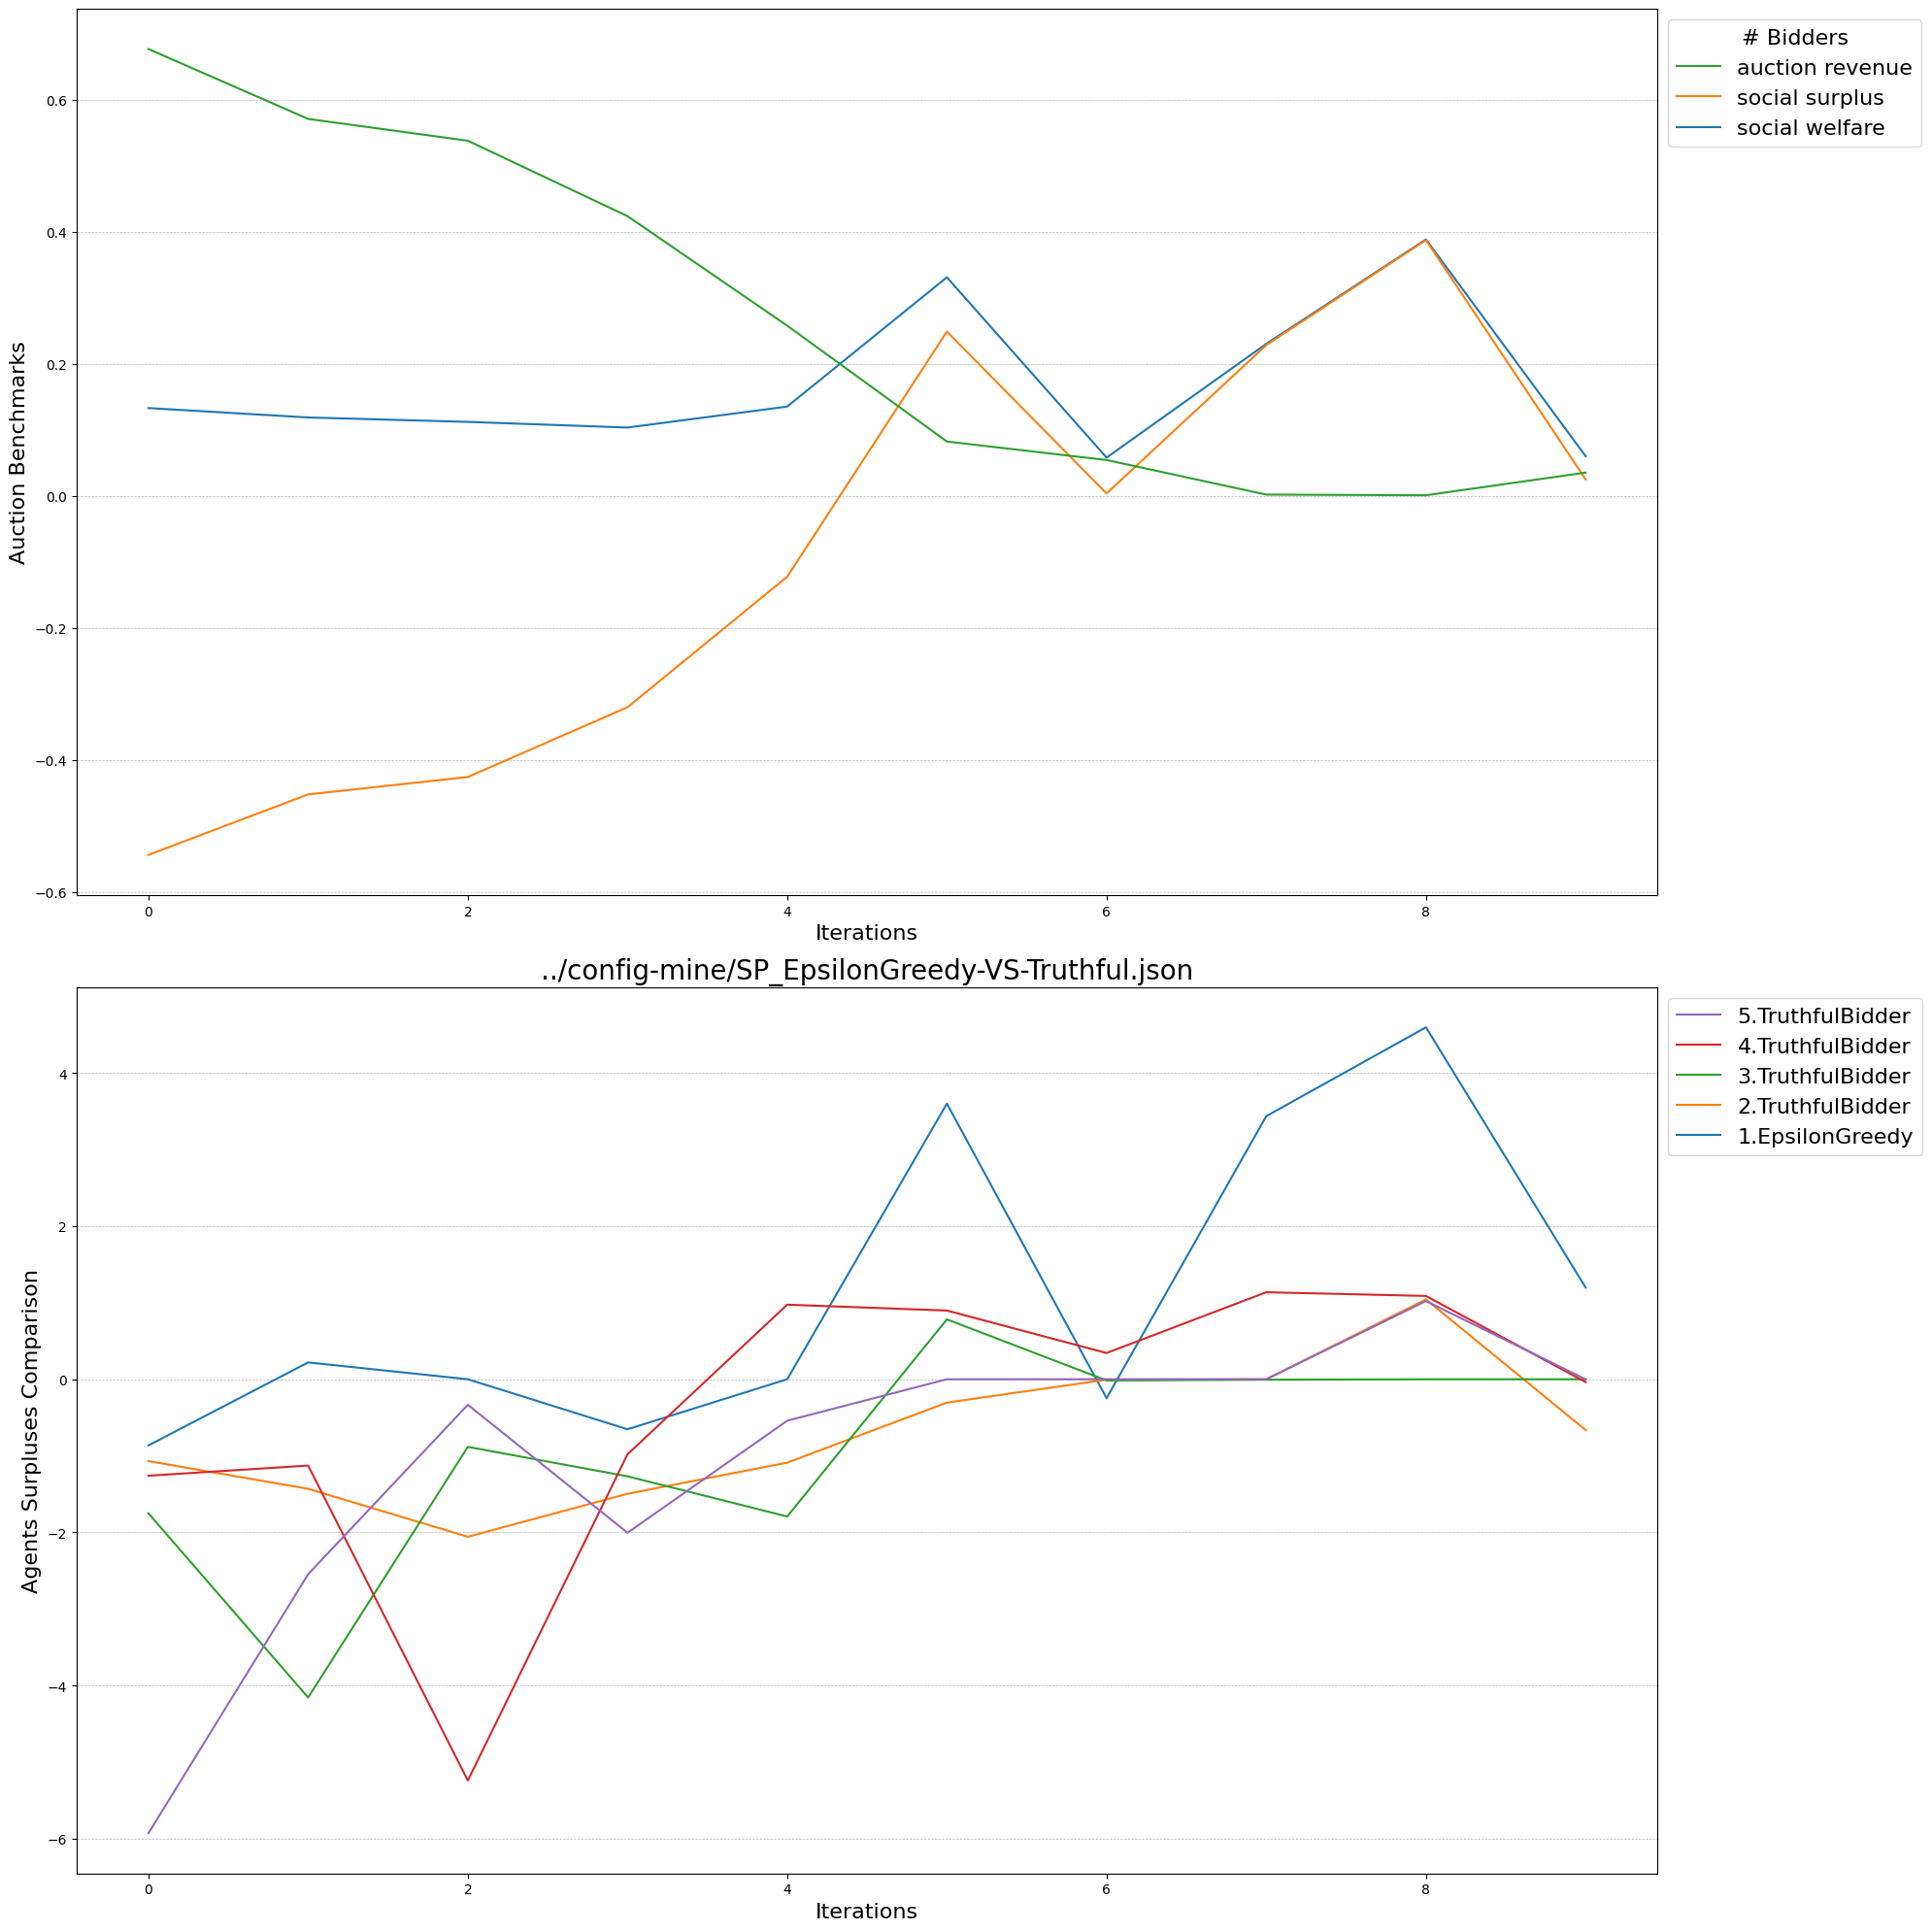

In [8]:
fontsize=16
fig, axes = plt.subplots(2,1, sharey='row', figsize=(20,20))

# for num_participants_per_round, (revenue, welfare, surplus) in num_participants_2_metrics.items():    
#     axes[0].plot(welfare, label=f'{num_participants_per_round}')
#     axes[1].plot(surplus, label=f'{num_participants_per_round}')
#     axes[2].plot(revenue, label=f'{num_participants_per_round}')

graph_auction_bench = axes[0]
graph_surpluses = axes[1]

revenue, welfare, surplus, agents_surplus = num_participants_2_metrics   
graph_auction_bench.plot(welfare, label=f'social welfare')
graph_auction_bench.plot(surplus, label=f'social surplus')
graph_auction_bench.plot(revenue, label=f'auction revenue')

for i, surplus in enumerate(agents_surplus):
    graph_surpluses.plot(surplus, label=my_agents_names[i])


graph_surpluses.set_title(graph_title, fontsize=fontsize+4)

for i in range(len(axes)):
    axes[i].set_xlabel('Iterations', fontsize=fontsize)
    axes[i].set_xticks(list(range(0,len(revenue),2)))
    axes[i].grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

    
graph_auction_bench.set_ylabel('Auction Benchmarks', fontsize=fontsize)
graph_surpluses.set_ylabel('Agents Surpluses Comparison', fontsize=fontsize)

handles, labels = graph_auction_bench.get_legend_handles_labels()
legend = graph_auction_bench.legend(reversed(handles),
                   reversed(labels),
                   loc='upper left',
                   bbox_to_anchor=(1.0, 1.0),
                   fontsize=fontsize)
legend.set_title('# Bidders', prop={'size': fontsize})

handles2, labels2 = graph_surpluses.get_legend_handles_labels()
legend2 = graph_surpluses.legend(reversed(handles2),
                         reversed(labels2),
                         loc='upper left',
                         bbox_to_anchor=(1.0, 1.0),
                         fontsize=fontsize)

fig.tight_layout()

plt.show()